This is a simple notebook that replicates https://mrf-web.readthedocs.io/en/latest/usage.html#usage

In [2]:
# needs correcting as the documentation a from MRF import *
from MacroRandomForest import *
import matplotlib.pyplot as plt
from scipy import stats, signal

In [3]:
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('./csvs/final_dataset.csv', index_col=0)
# df = df.tail(100)
# what is the purpose of trend?
# df['trend'] = np.arange(1, len(df) + 1)
# df.reset_index(drop=True, inplace=True)

# Function to detrend a series
def detrend_series(series):
    detrended = signal.detrend(series)
    return pd.Series(detrended, index=series.index)

# cannot display long column names
df.rename(columns={'government_expenditure': 'ge'}, inplace=True)
df.rename(columns={'balance_of_payments': 'bop'}, inplace=True)
df.rename(columns={'Rate': 'rate'}, inplace=True)

# Calculate the growth rates for 'gdp', 'ge', and 'bop' columns
df['gdp_growth'] = df['gdp'].pct_change().fillna(0)
df['ge_growth'] = df['ge'].pct_change().fillna(0)
df['bop_growth'] = df['bop'].pct_change().fillna(0)

# Detrend the 'gdp' column

df['gdp'] = detrend_series(df['gdp'])
df['ge'] = detrend_series(df['ge'])
df['bop'] = detrend_series(df['bop'])
df['gdp_growth'] = detrend_series(df['gdp_growth'])
df['ge_growth'] = detrend_series(df['ge_growth'])
df['bop_growth'] = detrend_series(df['bop_growth'])
# normalization 
# df = df.apply(stats.zscore)
scaler = MinMaxScaler()
# df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# there is a problem with the data - the dependent variable should be the first column
# Move the 'gdp' column to the first position
gdp_column = df.pop('gdp_growth')
df.insert(0, 'gdp_growth', gdp_column)

### Dependent Variable
my_var = "gdp_growth"
y_pos = df.columns.get_loc(my_var)

### Exogenous Variables
# S_vars = [f"sim_x{i}" for i in range(1, 16)] + ['trend']
S_vars = df.columns.tolist()
S_vars.remove(my_var)
S_pos = [df.columns.get_loc(s) for s in S_vars]

### Variables Included in Linear Equation
# changed from rate to balance of payments
# ge - government expenditure is a straight line
x_vars = ['inflation', 'ge_growth', 'rate', 'employment','bop_growth']
# x_vars = ['inflation', 'Rate']
x_pos = [df.columns.get_loc(x) for x in x_vars]
oos_pos = np.arange(len(df) - (12) , len(df)) # lower should be oos start, upper the length of your dataset

In [ ]:
# plt.plot(df['ge'])
y_pos = np.atleast_1d(y_pos)
x_pos = np.atleast_1d(x_pos)
S_pos = np.atleast_1d(S_pos)
oos_pos = np.atleast_1d(oos_pos)

number_of_trees = 100

MRF = MacroRandomForest(data = df,
                        y_pos = y_pos,
                        x_pos = x_pos,
                        # S_pos = S_pos,
                        B = number_of_trees, 
                        parallelise = True,
                        n_cores = -1,
                        resampling_opt = 2, 
                        # see _process_subsampling_selection in MRF
                        oos_pos = oos_pos,
                        trend_push = 4,
                        quantile_rate = 0.3,
                        print_b = True,
                        fast_rw = True,
                        keep_forest = True,)

In [31]:
MRF_output = MRF._ensemble_loop()

Tree 1 out of 100
Tree 7 out of 100
Tree 2 out of 100
Tree 8 out of 100
Tree 5 out of 100
Tree 4 out of 100
Tree 6 out of 100
Tree 10 out of 100
Tree 11 out of 100
Tree 9 out of 100
Tree 3 out of 100
Tree 12 out of 100
Tree 13 out of 100
Tree 14 out of 100
Tree 15 out of 100
Tree 16 out of 100
Tree 17 out of 100
Tree 18 out of 100
Tree 19 out of 100
Tree 20 out of 100
Tree 21 out of 100
Tree 22 out of 100
Tree 23 out of 100
Tree 24 out of 100
Tree 25 out of 100
Tree 26 out of 100
Tree 27 out of 100
Tree 28 out of 100
Tree 29 out of 100
Tree 30 out of 100
Tree 31 out of 100
Tree 32 out of 100
Tree 33 out of 100
Tree 34 out of 100
Tree 35 out of 100
Tree 36 out of 100
Tree 37 out of 100
Tree 38 out of 100
Tree 39 out of 100
Tree 40 out of 100
Tree 41 out of 100
Tree 42 out of 100
Tree 43 out of 100
Tree 44 out of 100
Tree 45 out of 100
Tree 46 out of 100
Tree 47 out of 100
Tree 48 out of 100
Tree 49 out of 100
Tree 50 out of 100
Tree 51 out of 100
Tree 52 out of 100
Tree 53 out of 100
Tr

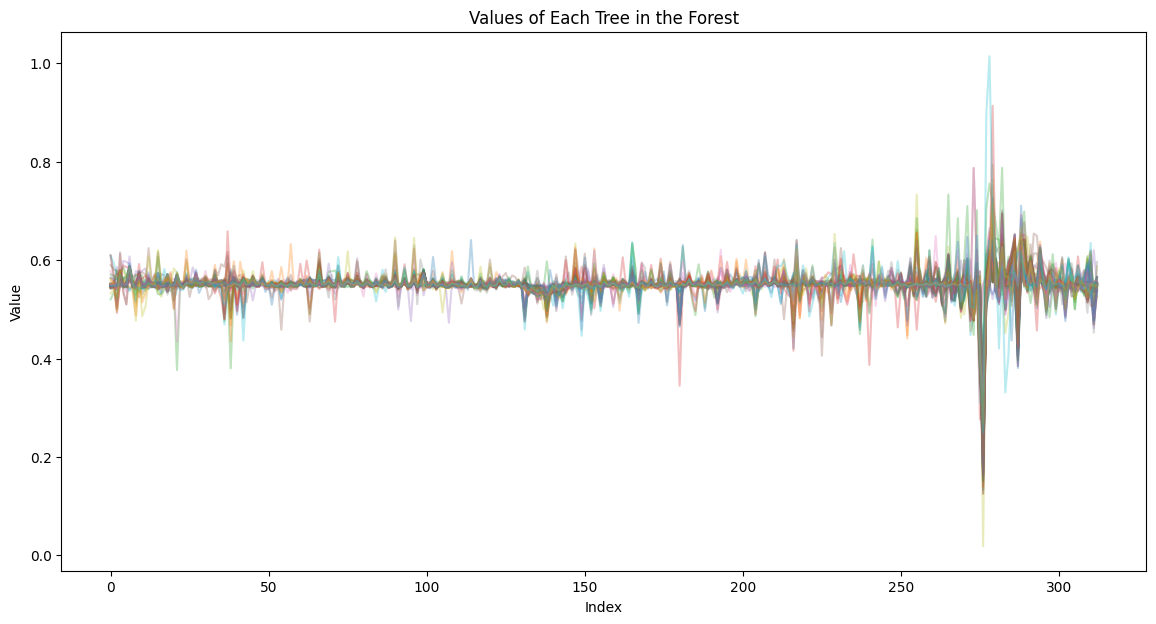

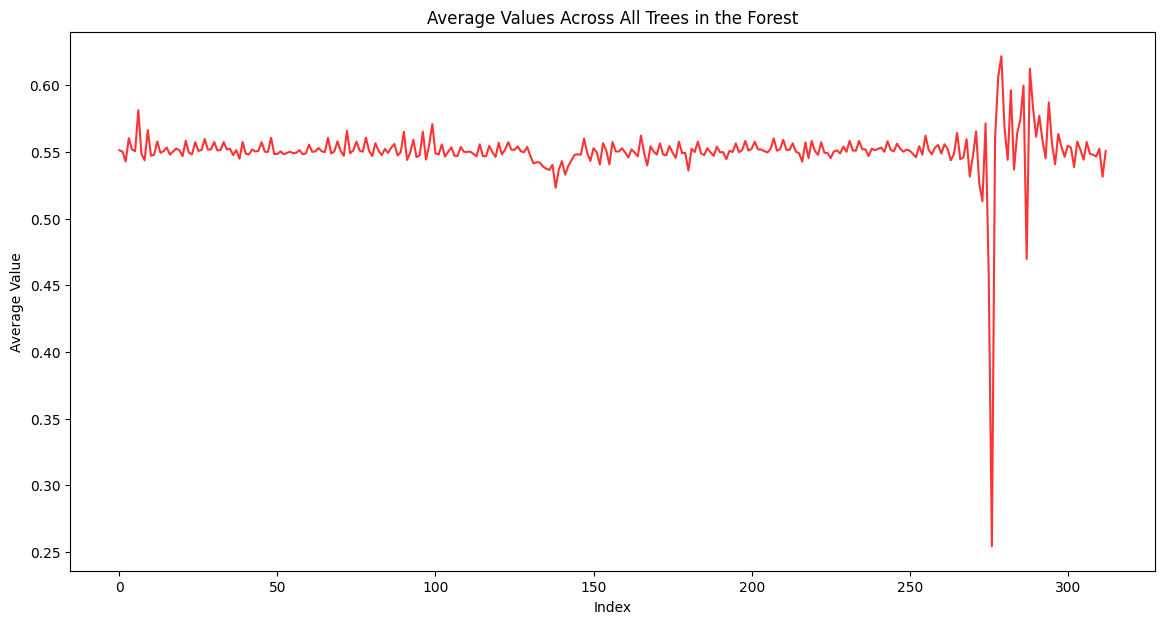

In [ ]:
plt.figure(figsize=(14, 7))
for tree in MRF_output['model']['forest']:
    plt.plot(MRF_output['model']['forest'][tree], alpha=0.3)
plt.title('Values of Each Tree in the Forest')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()



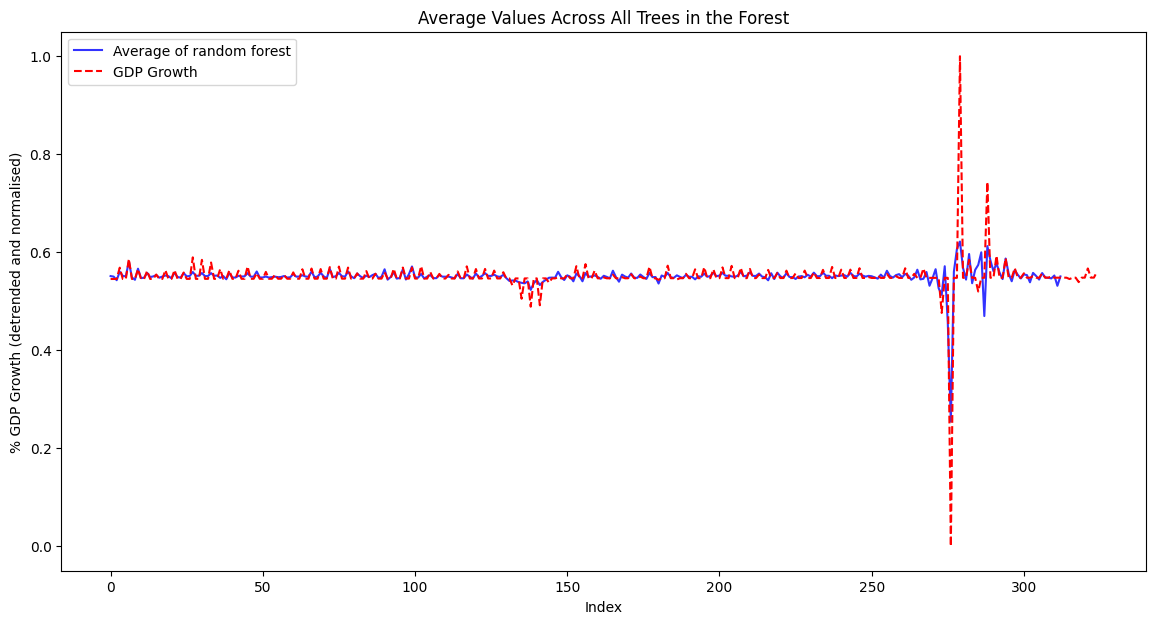

In [25]:
# Average across all trees in the forest
average_tree_values = np.mean([MRF_output['model']['forest'][tree] for tree in MRF_output['model']['forest']], axis=0)


plt.figure(figsize=(14, 7))
plt.plot(average_tree_values, alpha=0.8, color='blue', label='Average of random forest')
plt.title('Average Values Across All Trees in the Forest')
plt.xlabel('Index')
plt.ylabel('% GDP Growth (detrended and normalised)')
plt.plot(gdp_column, 'r--', label='GDP Growth')
plt.legend()
plt.show()

# todo transform back to the original basis and trend


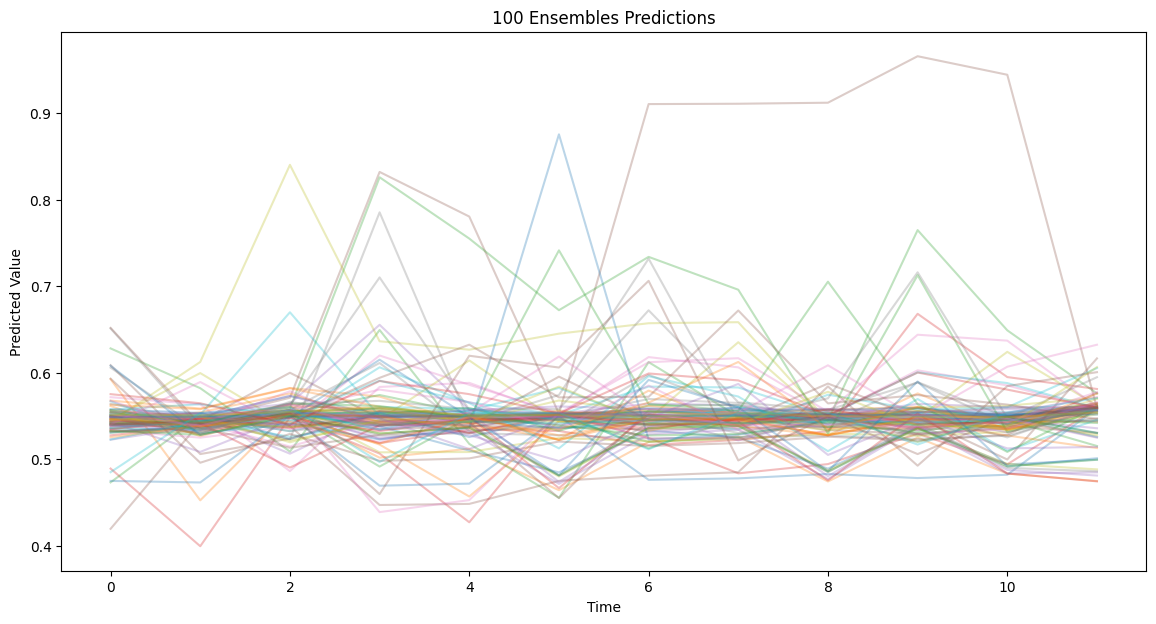

In [6]:
MRF_output['pred_ensemble']

plt.figure(figsize=(14, 7))
for i in range(number_of_trees):
    plt.plot(MRF_output['pred_ensemble'][i], alpha=0.3)
plt.title('100 Ensembles Predictions')
plt.xlabel('Time')
plt.ylabel('Predicted Value')
plt.show()

Text(0.5, 1.0, 'OOS predictions of MRF')

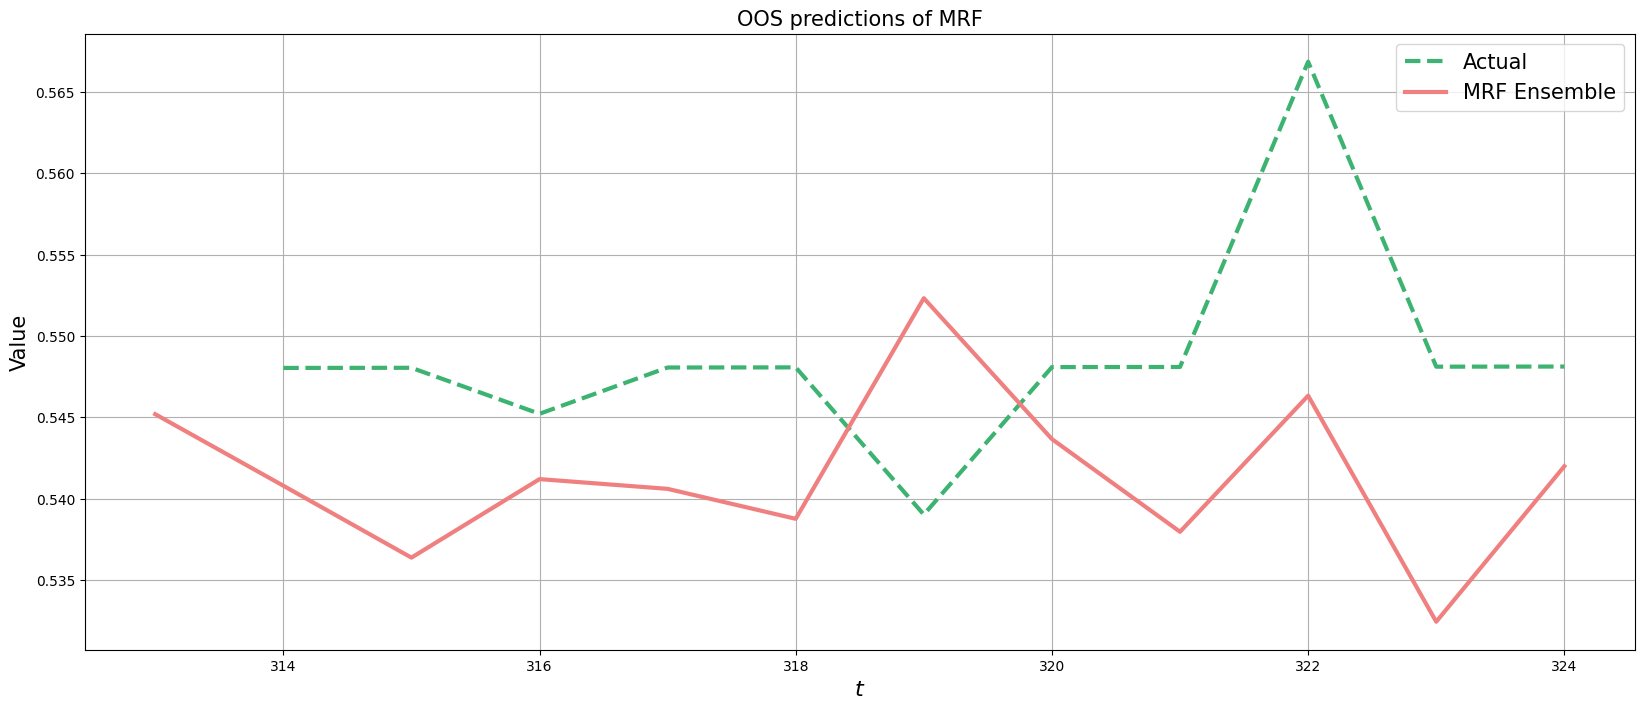

In [ ]:
forecasts = MRF_output['pred']
betas = MRF_output['betas']


fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = (20, 8)

# Plotting actual versus original
# column names has dissapeared

ax.plot(df.iloc[oos_pos, 0].shift(1), label='Actual', linewidth=3, color='mediumseagreen', linestyle='--')
ax.plot(forecasts, color='lightcoral', linewidth=3, label='MRF Ensemble')

ax.legend(fontsize = 15)
ax.set_ylabel("Value", fontsize = 15)
ax.grid()
ax.set_xlabel(r"$t$", fontsize = 16)
ax.set_title("OOS predictions of MRF", fontsize = 15)

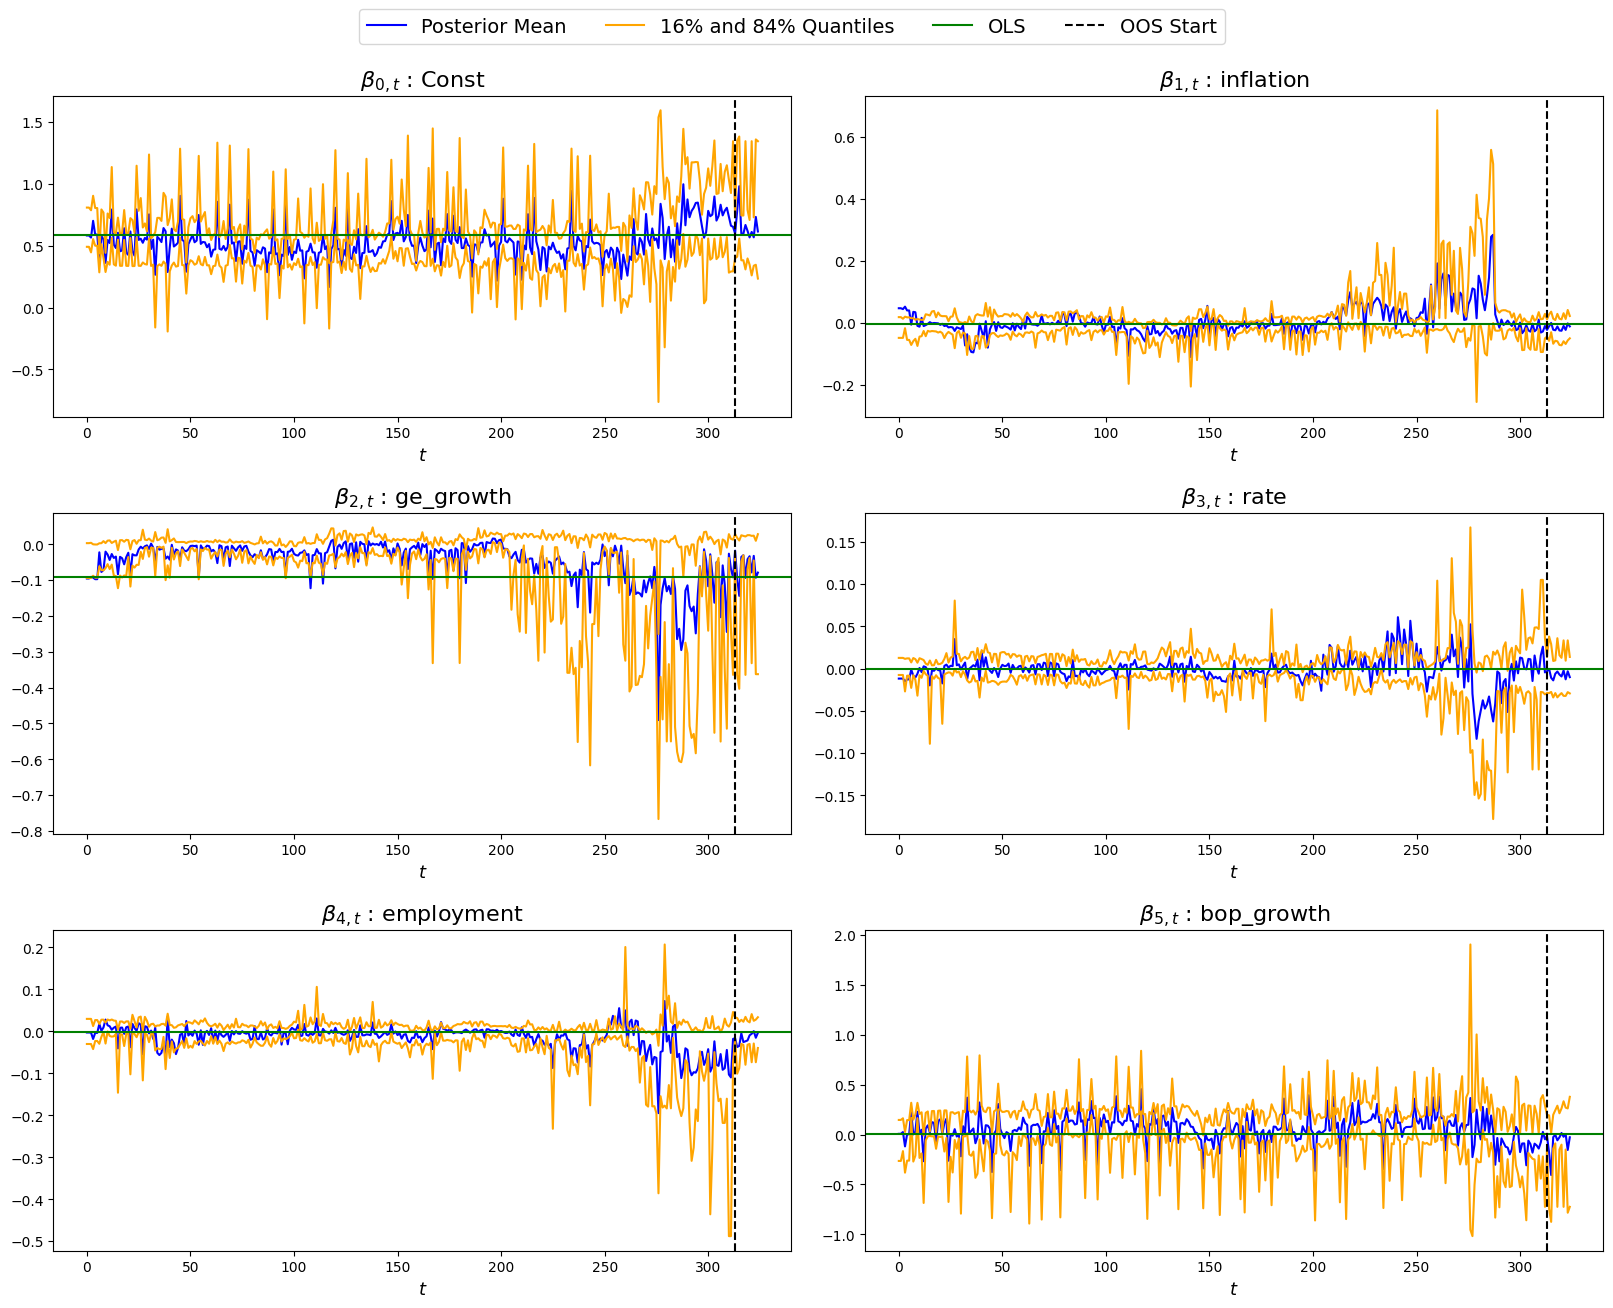

In [33]:
MRF.band_plots()

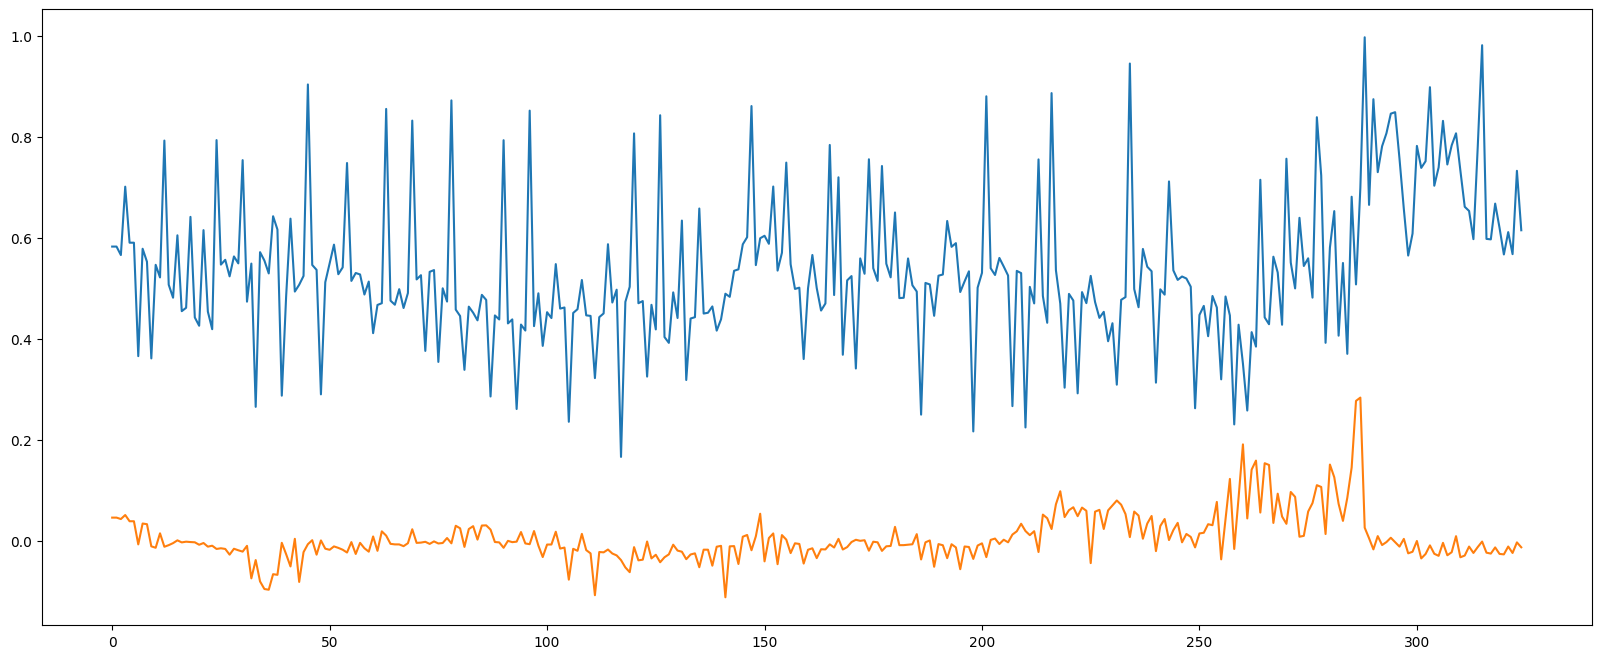

In [47]:
# individual output betas
plt.plot(MRF_output['betas'][:,0:2])
plt.show()

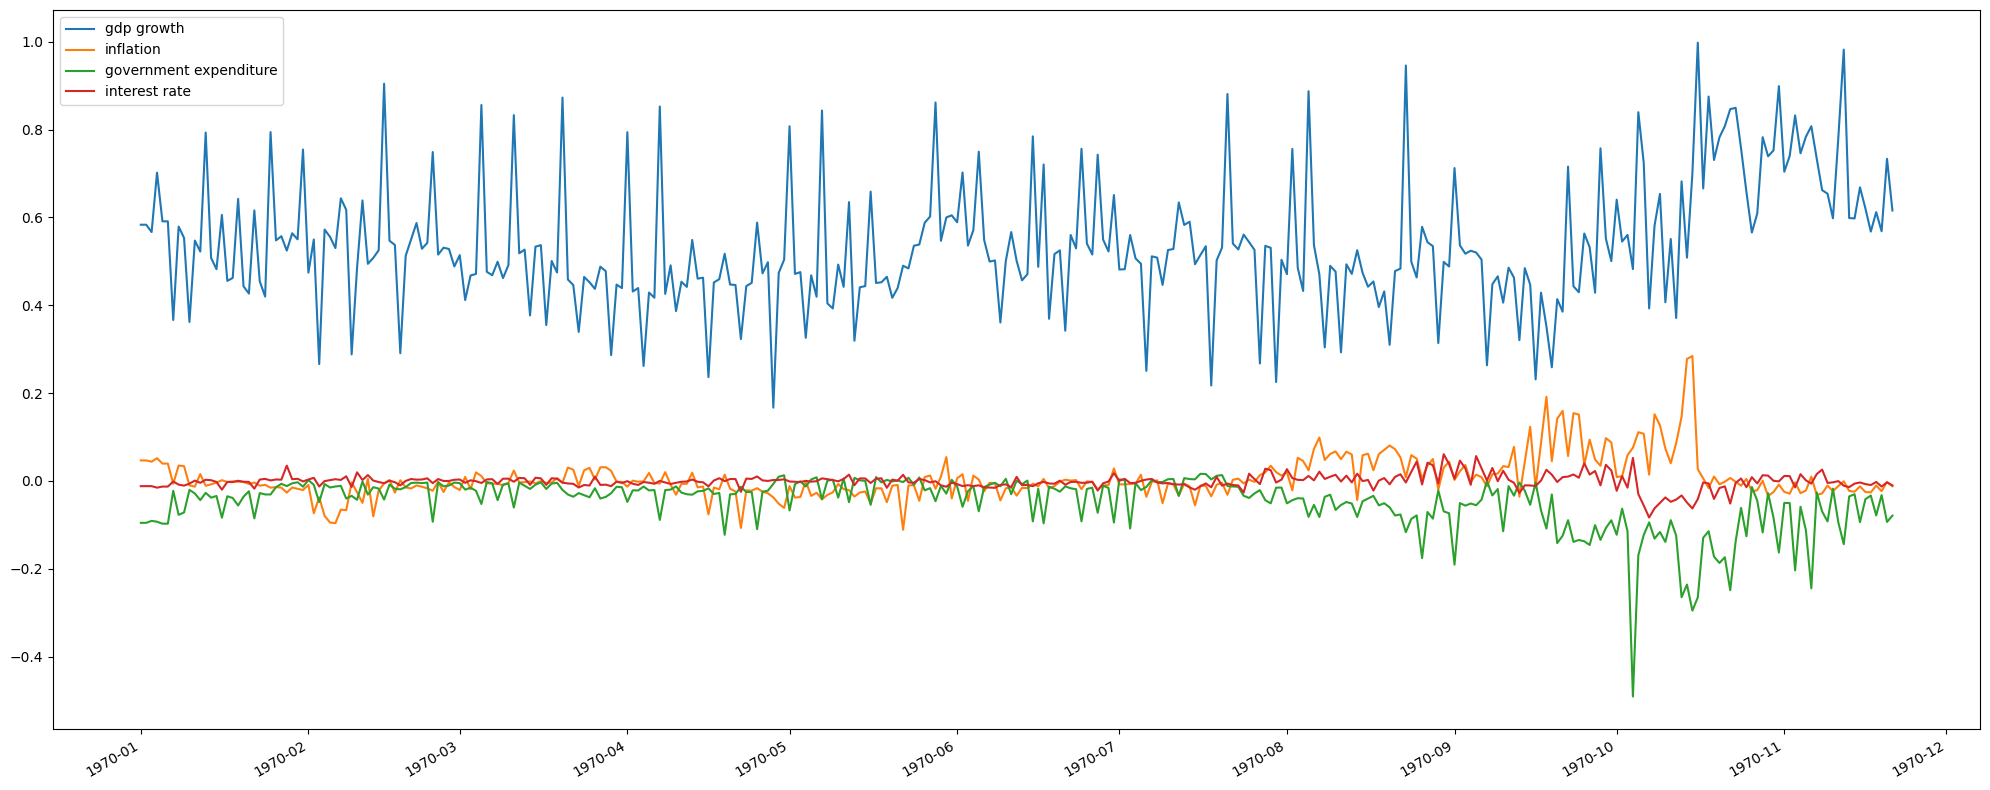

In [63]:
import matplotlib.dates as mdates

example_beta_output = pd.DataFrame(MRF_output['betas'][:,0:4], columns=['gdp growth', 'inflation', 'government expenditure', 'interest rate'])
orgin = pd.read_csv('csvs/final_dataset.csv', index_col=0)
example_beta_output.index = orgin.index[:len(example_beta_output)]
# Set the x-axis to display dates with a monthly frequency
# example_beta_output.index = pd.to_datetime(example_beta_output.index)
fig, ax = plt.subplots()
example_beta_output.plot(ax=ax)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [64]:
example_beta_output.to_clipboard()

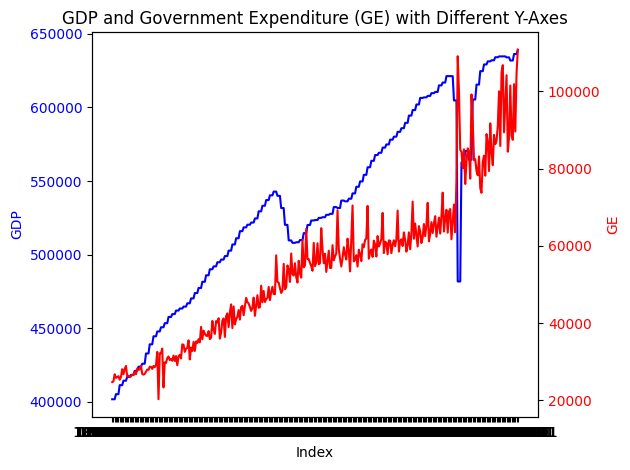

In [ ]:
df = pd.read_csv('final_dataset.csv', index_col=0)
fig, ax1 = plt.subplots()

# Plot gdp on the primary y-axis
ax1.plot(df.index, df['gdp'], color='blue', label='GDP')
ax1.set_xlabel('Index')
ax1.set_ylabel('GDP', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis and plot ge
ax2 = ax1.twinx()
ax2.plot(df.index, df['government_expenditure'], color='red', label='Government Expenditure (GE)')
ax2.set_ylabel('GE', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title and show the plot
plt.title('GDP and Government Expenditure (GE) with Different Y-Axes')
fig.tight_layout()
plt.show()